# Tensorflow - Cat State Detect - Project

![Ảnh minh họa mèo](https://i.ytimg.com/vi/HIdLXBn-Py0/maxresdefault.jpg)

# Xây dựng mô hình ANN và CNN cho bài toán
- Với ANN, ta sẽ trích xuất các đặc trưng của âm thanh và sắp xếp chúng thành hàng (vector) và cho chúng là dữ liệu đầu vào để huấn luyện mô hình dự đoán.
- Với CNN, ta sẽ sử dụng Mel Spectrogram hoặc STFT để biểu diễn dữ liệu (âm thanh) giống như hình ảnh (2D) sau đó đưa vào vào huấn luyện mô hình dự đoán.

## 1. Import thư viện cần thiết

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import IPython.display as ipd
import librosa
import librosa.display

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_io as tfio


import warnings
warnings.filterwarnings("ignore")

Kiểm tra xem tensorflow đang sử dụng GPU (khuyến khích) hay CPU

In [2]:
print(tf.config.list_physical_devices('GPU'))
tf.test.is_gpu_available()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

## 2. Phân tích khai phá dữ liệu (EDA)

- Kiểm tra sơ đồ thư mục

In [3]:
DATA_PATH = 'dataset/dataset/'

In [4]:
# Trạng thái mèo 'F' : 'Waiting For Food', 'I' : 'Isolated in unfamiliar Environment', 'B' : 'Brushing'
wav_dict = {'F' : [], 'I' : [], 'B' : []}

for path in os.listdir(DATA_PATH):
    list_split = path.split('_')
    if list_split[0] in wav_dict.keys():
        wav_dict[list_split[0]].append(path)

In [5]:
print(f"Trong thư mục {DATA_PATH} có: {len(os.listdir(DATA_PATH))} files")
for key in wav_dict:
    print(f"--> Lớp {key} có {len(wav_dict[key])} files")

Trong thư mục dataset/dataset/ có: 440 files
--> Lớp F có 92 files
--> Lớp I có 221 files
--> Lớp B có 127 files


- Tạo Dataframe

In [6]:
state = []
state_sample = {'F' : 'Waiting For Food', 'I' : 'Isolated in unfamiliar Environment', 'B' : 'Brushing'}
cat_id = []
cat_type = []
cat_type_sample = {'MC' : 'Maine Coon', 'EU': 'European Shorthair'}
sex = []
owner_id = []  
recording_session = [] 
meow_counter = []
audio_path = []

for path in os.listdir(DATA_PATH):
    list_split = path.split('_')
    if list_split[0] in state_sample.keys():
        state.append(state_sample[list_split[0]])
    else:
        state.append('Unknown')
    cat_id.append(list_split[1])
    if list_split[2] in cat_type_sample.keys():
        cat_type.append(cat_type_sample[list_split[2]])
    else:
        cat_type.append('Unknown')
    sex.append(list_split[3])
    owner_id.append(list_split[4])
    recording_session.append(int(list_split[5][0]))
    meow_counter.append(int(list_split[5][1:3]))
    audio_path.append(path)
    
    

In [7]:
# Tạo DataFrame từ các danh sách đã thu thập dữ liệu
data = {
    'Cat_ID': cat_id,
    'State': state,
    'Cat_Type': cat_type,
    'Sex': sex,
    'Owner_ID': owner_id,
    'Recording_Session': recording_session,
    'Meow_Counter': meow_counter,
    'Audio_Path': audio_path
}

df = pd.DataFrame(data)
df.head(5)

,Cat_ID,State,Cat_Type,Sex,Owner_ID,Recording_Session,Meow_Counter,Audio_Path
0,ANI01,Brushing,Maine Coon,FN,SIM01,1,1,B_ANI01_MC_FN_SIM01_101.wav
1,ANI01,Brushing,Maine Coon,FN,SIM01,1,2,B_ANI01_MC_FN_SIM01_102.wav
2,ANI01,Brushing,Maine Coon,FN,SIM01,1,3,B_ANI01_MC_FN_SIM01_103.wav
3,ANI01,Brushing,Maine Coon,FN,SIM01,3,1,B_ANI01_MC_FN_SIM01_301.wav
4,ANI01,Brushing,Maine Coon,FN,SIM01,3,2,B_ANI01_MC_FN_SIM01_302.wav


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Cat_ID             440 non-null    object
 1   State              440 non-null    object
 2   Cat_Type           440 non-null    object
 3   Sex                440 non-null    object
 4   Owner_ID           440 non-null    object
 5   Recording_Session  440 non-null    int64 
 6   Meow_Counter       440 non-null    int64 
 7   Audio_Path         440 non-null    object
dtypes: int64(2), object(6)
memory usage: 27.6+ KB


In [9]:
for col in df.columns:
    if col != "Audio_Path":
        print(df[col].unique())

['ANI01' 'BAC01' 'BRA01' 'BRI01' 'CAN01' 'DAK01' 'IND01' 'JJX01' 'MAG01'
 'MAT01' 'MIN01' 'NIG01' 'NUL01' 'REG01' 'SPI01' 'TIG01' 'WHO01' 'BLE01'
 'LEO01' 'MEG01' 'CLE01']
['Brushing' 'Waiting For Food' 'Isolated in unfamiliar Environment']
['Maine Coon' 'European Shorthair']
['FN' 'MN' 'FI' 'MI']
['SIM01' 'GIA01' 'ELI01' 'FED01' 'RIT01' 'BEN01' 'GIO01' 'NAI01' 'GIU01'
 'DEL01' 'SIM10' 'FER01']
[1 3 2 4]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


In [10]:
print(f"Số dòng có giá trị null: \n{df.isnull().sum()}")
print(f"Số dòng duplicated: {df.duplicated().sum()}")

Số dòng có giá trị null: 
Cat_ID               0
State                0
Cat_Type             0
Sex                  0
Owner_ID             0
Recording_Session    0
Meow_Counter         0
Audio_Path           0
dtype: int64
Số dòng duplicated: 0


In [11]:
df.describe()

,Recording_Session,Meow_Counter
count,440.000000,440.000000
mean,1.902273,4.406818
std,0.875896,4.001759
min,1.000000,1.000000
25%,1.000000,2.000000
50%,2.000000,3.000000
75%,3.000000,5.250000
max,4.000000,21.000000


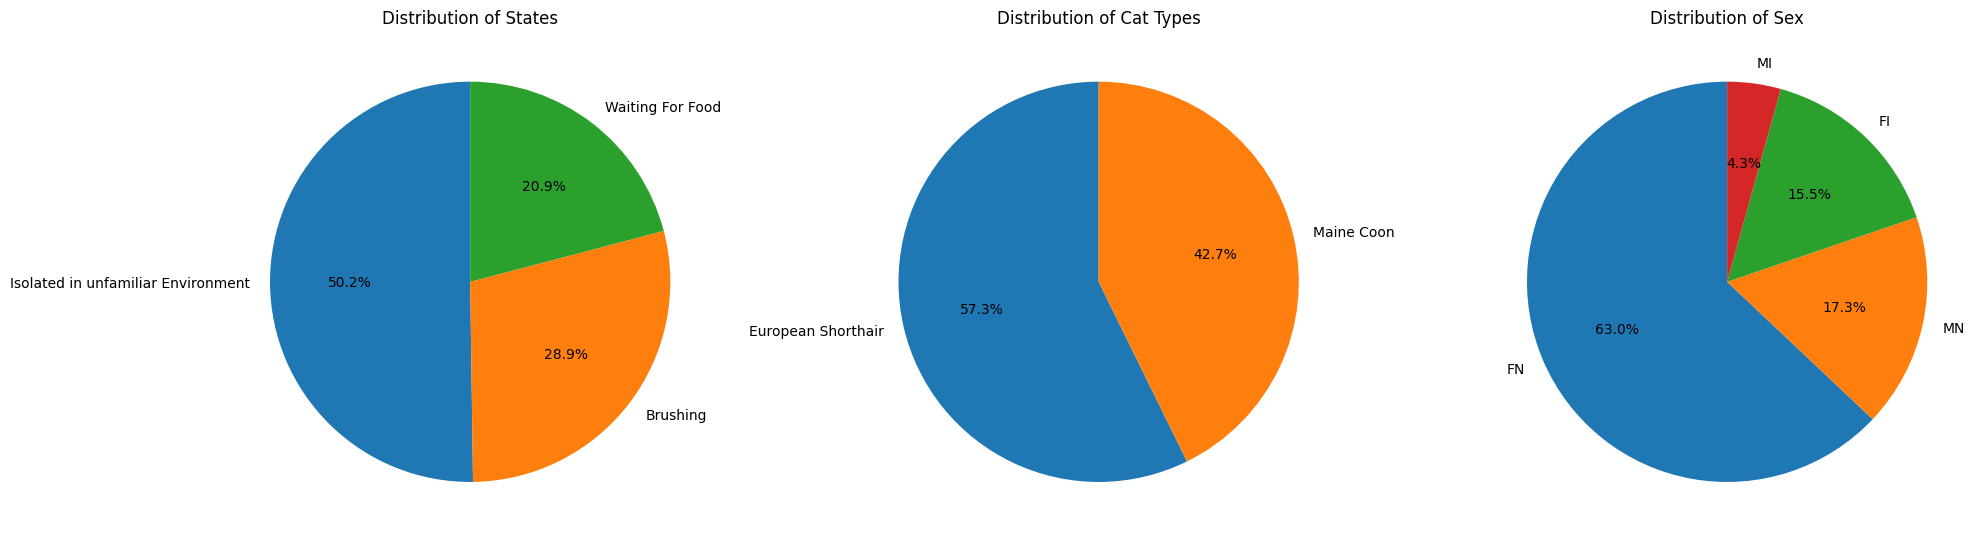

In [12]:
# Vẽ các biểu đồ tròn
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
state_counts = df['State'].value_counts()
axs[0].pie(state_counts, labels=state_counts.index, autopct='%1.1f%%', startangle=90)
axs[0].set_title('Distribution of States')
cat_type_counts = df['Cat_Type'].value_counts()
axs[1].pie(cat_type_counts, labels=cat_type_counts.index, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Distribution of Cat Types')
sex_counts = df['Sex'].value_counts()
axs[2].pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=90)
axs[2].set_title('Distribution of Sex')

plt.tight_layout()
plt.show()

- Kiểm tra ngẫu nhiên file audio

In [13]:
random_rows = df.sample(n=12)
filepath = DATA_PATH + random_rows.iloc[0].Audio_Path
data , sample_rate = librosa.load(filepath)
librosa.load(filepath)
sample_rate

22050

In [14]:
ipd.Audio(filepath)

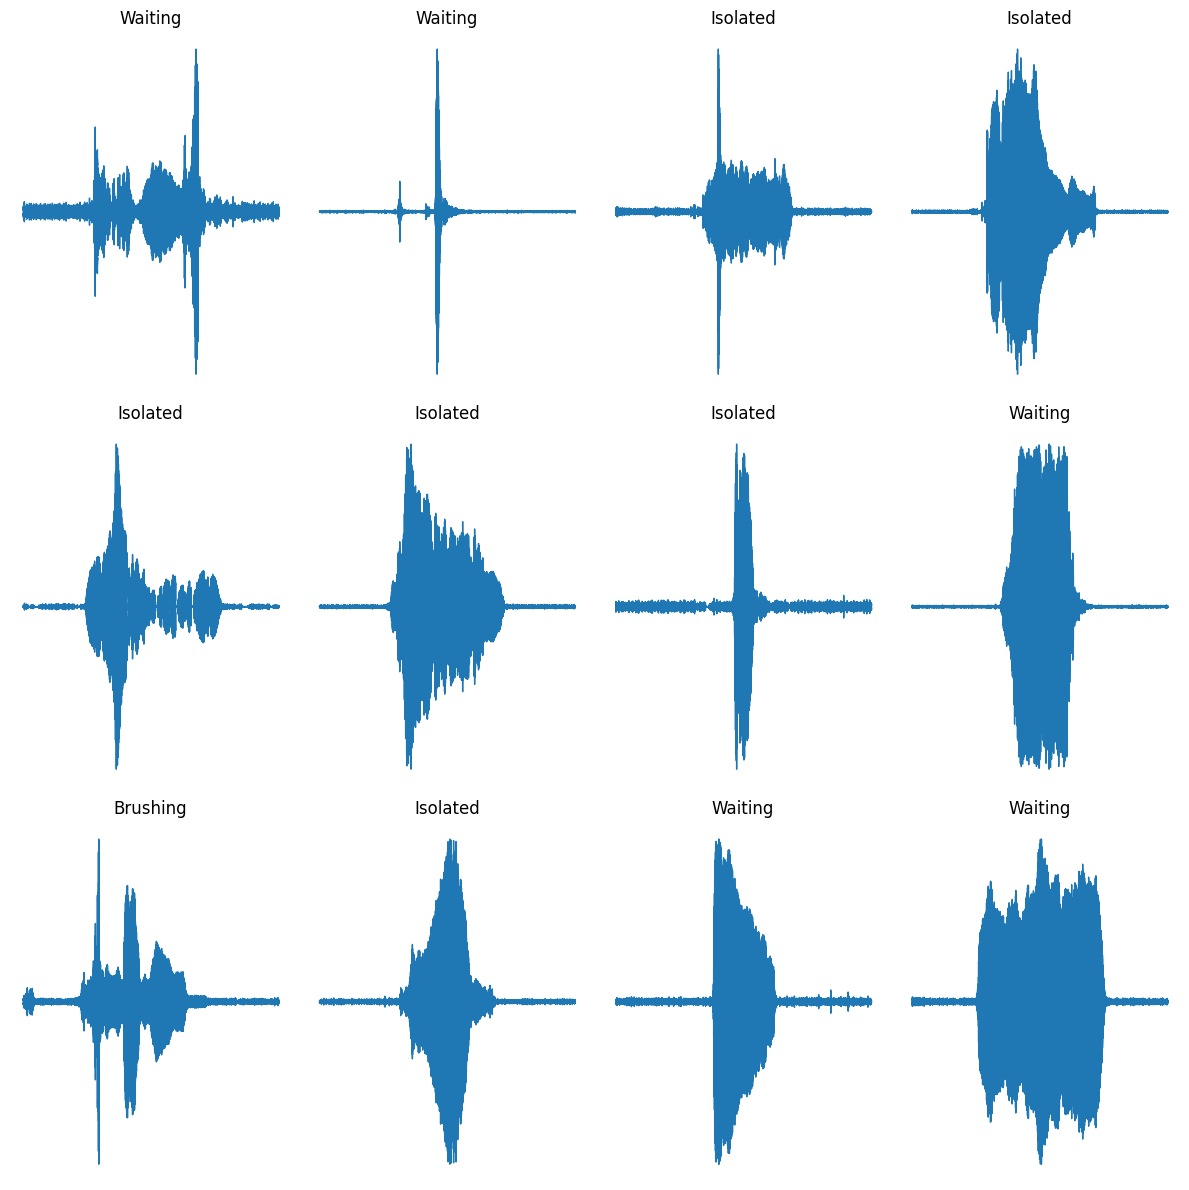

In [15]:
plt.figure(figsize=(12,12))
for i in range(12):
    random_row = random_rows.iloc[i]
    axs = plt.subplot(3,4,i+1)
    filepath = DATA_PATH + random_row.Audio_Path
    data , sample_rate = librosa.load(filepath)
    librosa.load(filepath)
    librosa.display.waveshow(data,ax=axs)
    plt.title(random_row.State.split(" ")[0])
    plt.axis("off")

plt.tight_layout()
plt.show()

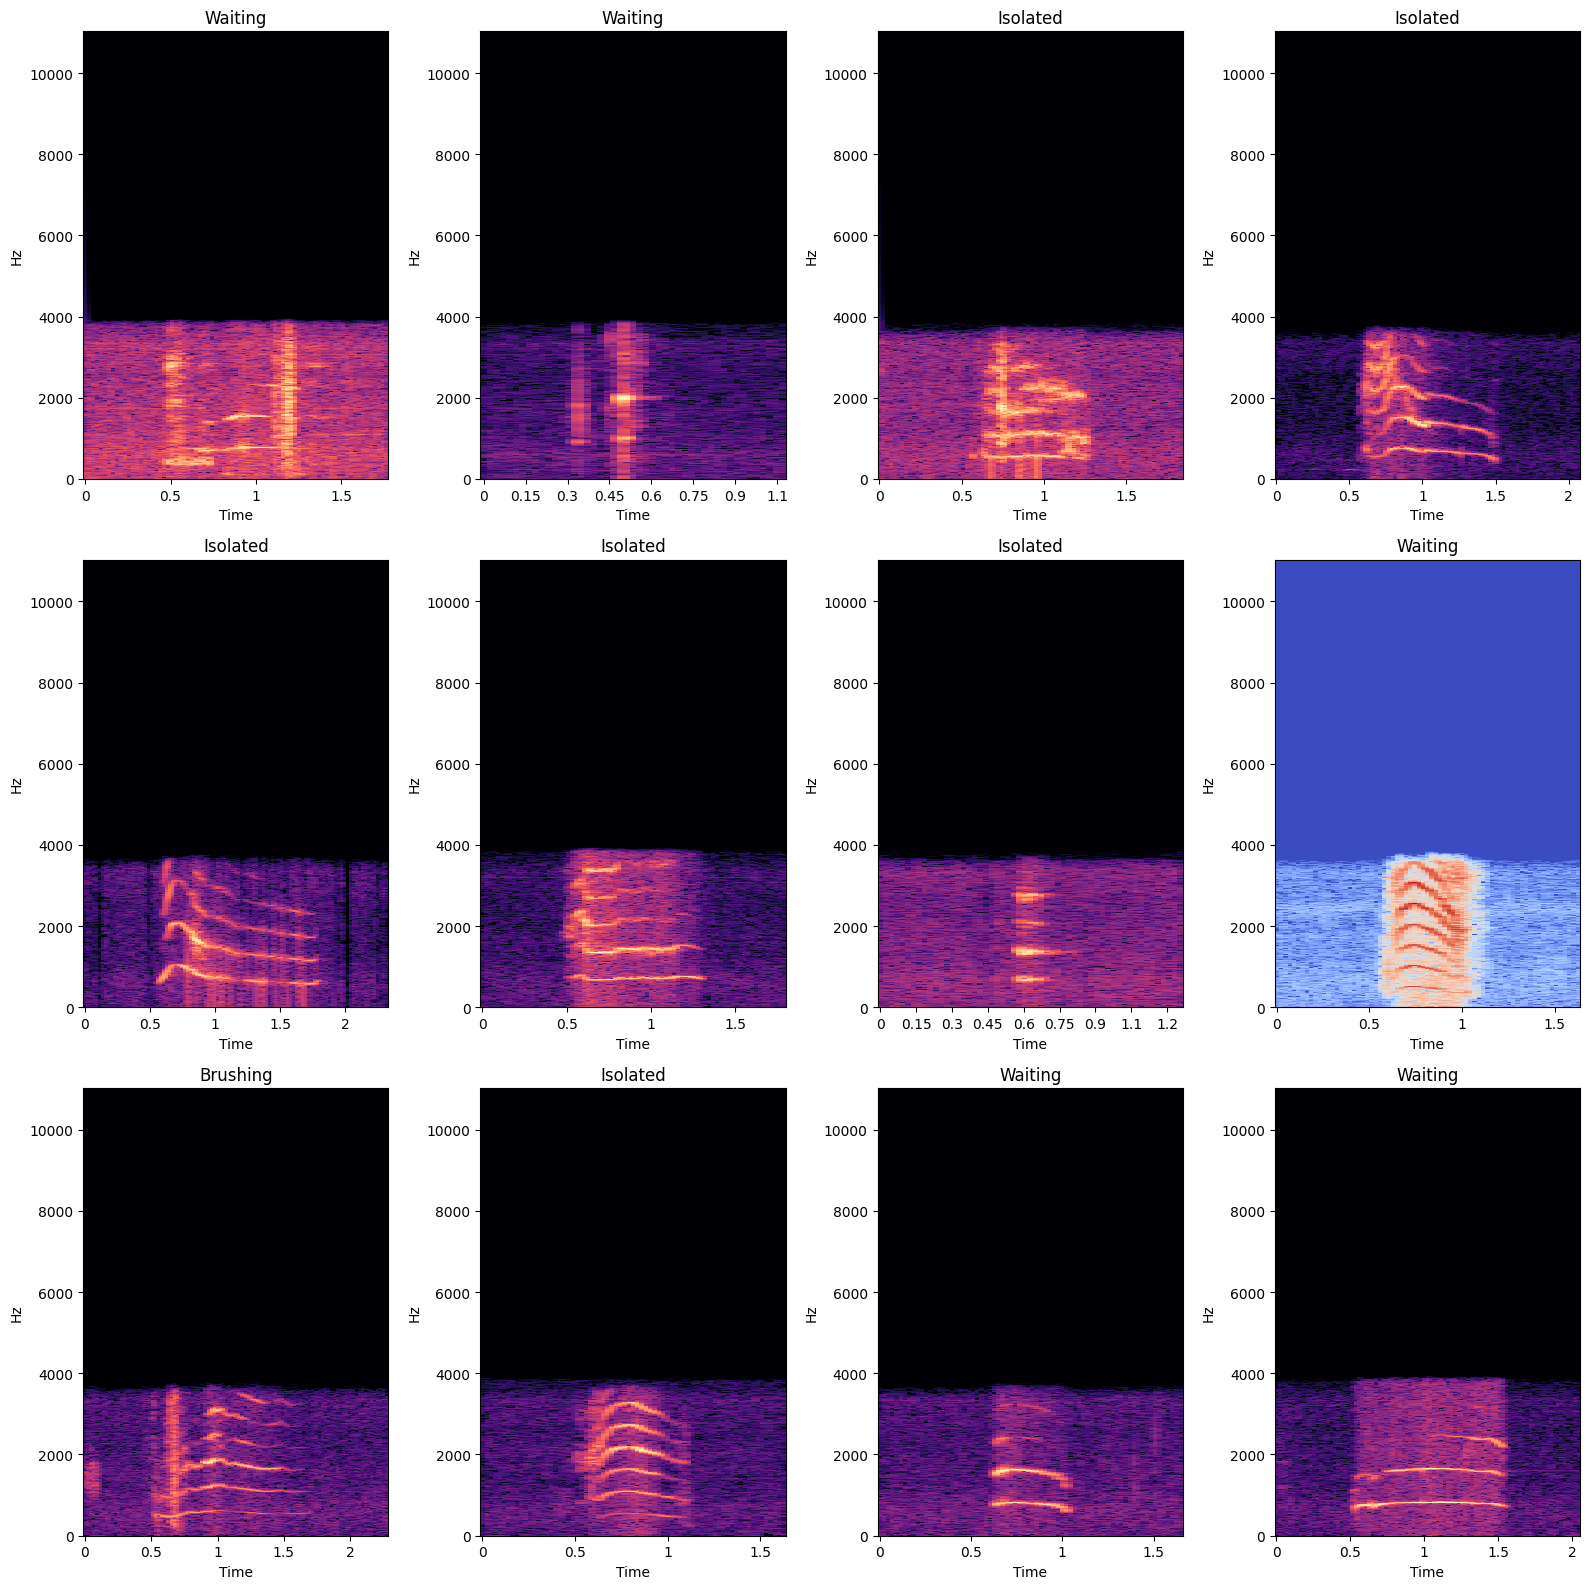

In [16]:
plt.figure(figsize=(16,16))
for i in range(12):
    random_row = random_rows.iloc[i]
    axs = plt.subplot(3,4,i+1)
    filepath = DATA_PATH + random_row.Audio_Path
    data , sample_rate = librosa.load(filepath)
    librosa.load(filepath)
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz',ax=axs)
    plt.title(random_row.State.split(" ")[0])

plt.tight_layout()
plt.show()

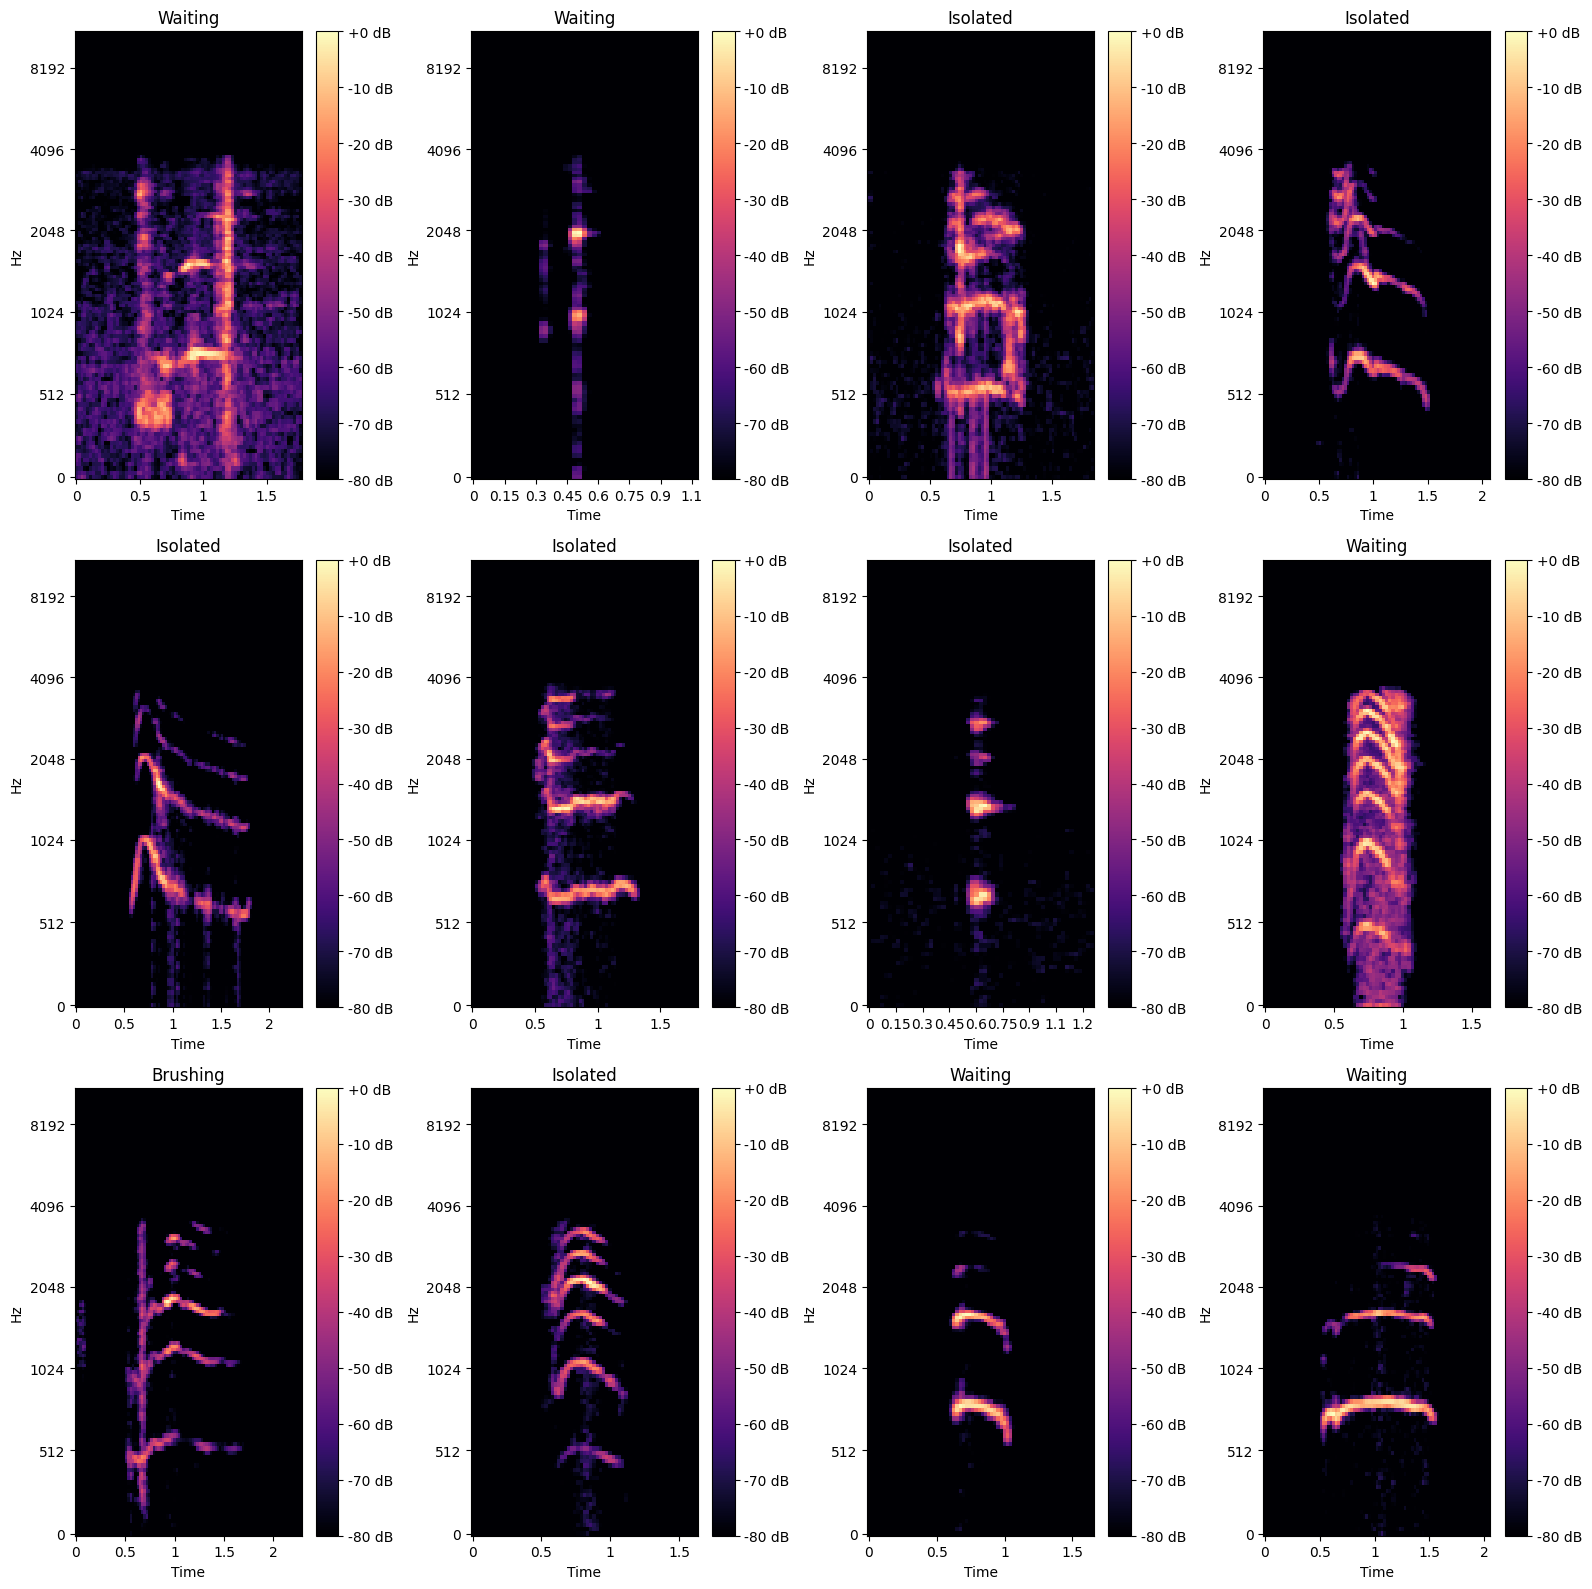

In [17]:
plt.figure(figsize=(16,16))
for i in range(12):
    random_row = random_rows.iloc[i]
    axs = plt.subplot(3, 4, i+1)
    filepath = DATA_PATH + random_row.Audio_Path
    data, sample_rate = librosa.load(filepath)
    S = librosa.feature.melspectrogram(y=data, sr=sample_rate, n_mels=128)
    S_db = librosa.amplitude_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_db, sr=sample_rate, x_axis='time', y_axis='mel', ax=axs)
    plt.title(random_row.State.split(" ")[0])
    plt.colorbar(img, ax=axs, format='%+2.0f dB')

plt.tight_layout()
plt.show()

## 3. Tạo tập dữ liệu train và test

### 3.1. Một số hàm cần thiết

- Load file wav và nén theo sample rate đầu vào

In [18]:
def wav_to_array(path,sample_rate):
    array_wav, sr = librosa.load(path,sr=sample_rate)
    return array_wav, sr

- Trích xuất Mel Spectrogram

In [19]:
def mel_spectogram(data, sr, mel=128):
    S = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=mel)
    S_dB = librosa.amplitude_to_db(S, ref=np.max)
    return S_dB

- Trích xuất STFT (Short-Time Fourier Transform)

In [20]:
def stft(data):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    return Xdb

- Tăng cường dữ liệu (data augmentation)

In [21]:
# Thêm nhiễu Gaussian vào tín hiệu âm thanh gốc.
def noise(data):
    noise_amp = 0.025 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

In [22]:
# Thay đổi tốc độ phát âm thanh mà không thay đổi cao độ.
def stretch(data):
    return librosa.effects.time_stretch(data, rate=0.9)

In [23]:
# Thay đổi cao độ của tín hiệu âm thanh mà không thay đổi tốc độ.
def pitch(data, sr):
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=3)

- Trích xuất đặc trưng ảnh

In [24]:
# Zero Crossing Rate (ZCR): Tần suất mà tín hiệu âm thanh đi qua trục hoành (giá trị zero)
def ZCR(data):
    return np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)

In [25]:
# Trích xuất mean chroma của STFT (Short-Time Fourier Transform): Biến đổi Fourier ngắn hạn để phân tích tần số.
def Mean_chroma_STFT(data):
    stft = np.abs(librosa.stft(data))
    return np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)

In [26]:
# MFCC (Mel-frequency cepstral coefficients): Hệ số cepstral trong thang đo Mel, thường dùng trong nhận dạng giọng nói.
def MFCC(data):
    return np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)

In [27]:
# Root Mean Square Value (RMS): Giá trị trung bình bình phương gốc của tín hiệu âm thanh, biểu thị năng lượng.
def RMS(data):
    return np.mean(librosa.feature.rms(y=data).T, axis=0)

In [28]:
# Mel Spectrogram: Biểu đồ biểu diễn năng lượng tín hiệu âm thanh trong thang Mel.
def MS(data):
    return np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)

In [29]:
def Extract_Allfeatures(data):
    features = [ZCR(data),Mean_chroma_STFT(data),MFCC(data),RMS(data),MS(data)]
    result = features[0]
    for i in range(1,len(features)):
        result = np.hstack((result,features[i]))
    return result

### 3.2. Tiền xử lý, biến đổi dữ liệu thành đặc trưng cho từng mô hình và chia tập dữ liệu

In [30]:
class DataCustom:
    class ANN:
        @staticmethod
        def Preprocessing(wav_dict,key_map,data_augmentation=False,number_of_augmentation=1,sample_rate=16000):
            X = []
            y = []
            for key in wav_dict:
                for path in wav_dict[key]:
                    array_wav, sr = wav_to_array(DATA_PATH + path,sample_rate)
                    features = Extract_Allfeatures(array_wav)
                    X.append(features)
                    y.append(key_map[key])
                    if data_augmentation:
                        for i in range(number_of_augmentation):
                            noise_array_wav = noise(array_wav)
                            features = Extract_Allfeatures(noise_array_wav)
                            X.append(features)
                            y.append(key_map[key])
                            stretch_array_wav = stretch(array_wav)
                            features = Extract_Allfeatures(stretch_array_wav)
                            X.append(features)
                            y.append(key_map[key])
                            pitch_array_wav = pitch(array_wav,sample_rate)
                            features = Extract_Allfeatures(pitch_array_wav)
                            X.append(features)
                            y.append(key_map[key])
            X = np.array(X)
            y = np.array(y)
            input_shape = X.shape[1:]
            return X,y,input_shape
    class CNN:
        @staticmethod
        def Preprocessing_STFT(wav_dict,key_map,data_augmentation=False,sample_rate=16000):
            X = []
            X_temp = []
            y = []
            max_length = 0
            for key in wav_dict:
                for path in wav_dict[key]:
                    array_wav, sr = wav_to_array(DATA_PATH + path,sample_rate)
                    s = stft(array_wav)
                    X_temp.append(s)
                    y.append(key_map[key])
                    max_length = max(max_length, s.shape[1])
                    if data_augmentation:
                        noise_array_wav = noise(array_wav)
                        s = stft(noise_array_wav)
                        X_temp.append(s)
                        y.append(key_map[key])
                        max_length = max(max_length, s.shape[1])
                        stretch_array_wav = stretch(array_wav)
                        s = stft(stretch_array_wav)
                        X_temp.append(s)
                        y.append(key_map[key])
                        max_length = max(max_length, s.shape[1])
                        pitch_array_wav = pitch(array_wav,sample_rate)
                        s = stft(pitch_array_wav)
                        X_temp.append(s)
                        y.append(key_map[key])
                        max_length = max(max_length, s.shape[1])
                    

            for s in X_temp:
                current_length = s.shape[1]
                if current_length < max_length:
                    pad_width = max_length - current_length
                    s = np.pad(s, ((0, 0), (0, pad_width)), mode='constant')
                else:
                    s = s[:, :max_length]
                X.append(np.expand_dims(s, axis=-1))
            X = np.array(X)
            y = np.array(y)
            input_shape = X.shape[1:]
            return X,y,input_shape

        @staticmethod
        def Preprocessing_MelSpectogram(wav_dict,key_map,data_augmentation=False,sample_rate=16000):
            X = []
            X_temp = []
            y = []
            max_length = 0
            for key in wav_dict:
                for path in wav_dict[key]:
                    array_wav, sr = wav_to_array(DATA_PATH + path,sample_rate)
                    s = mel_spectogram(array_wav,sample_rate)
                    X_temp.append(s)
                    max_length = max(max_length, s.shape[1])
                    if data_augmentation:
                        noise_array_wav = noise(array_wav)
                        s = mel_spectogram(array_wav,sample_rate)
                        X_temp.append(s)
                        max_length = max(max_length, s.shape[1])
                        stretch_array_wav = stretch(array_wav)
                        s = mel_spectogram(array_wav,sample_rate)
                        X_temp.append(s)
                        max_length = max(max_length, s.shape[1])
                        pitch_array_wav = pitch(array_wav,sample_rate)
                        s = mel_spectogram(array_wav,sample_rate)
                        X_temp.append(s)
                        max_length = max(max_length, s.shape[1])
                    y.append(key_map[key])

            for s in X_temp:
                current_length = s.shape[1]
                if current_length < max_length:
                    pad_width = max_length - current_length
                    s = np.pad(s, ((0, 0), (0, pad_width)), mode='constant')
                else:
                    s = s[:, :max_length]
                X.append(np.expand_dims(s, axis=-1))
            X = np.array(X)
            y = np.array(y)
            input_shape = X.shape[1:]
            return X,y,input_shape
    @staticmethod
    def datasplit(X,y,random_state,test_size,shuffle=True):
        X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=random_state,test_size=test_size,shuffle=shuffle)
        return X_train, X_test, y_train, y_test

## 4. Xây dựng mô hình

In [31]:
wav_dict.keys()

dict_keys(['F', 'I', 'B'])

In [32]:
key_map = {
    'F':np.array([1,0,0]),
    'I':np.array([0,1,0]),
    'B':np.array([0,0,1])
}

### 4.1. ANN - Artificial Neural Network

- Tiền xử lý dữ liệu và chia dữ liệu cho ANN

In [33]:
X_ann, y_ann, inputshape_ann = DataCustom.ANN.Preprocessing(wav_dict,key_map,data_augmentation=True,number_of_augmentation=2,sample_rate=16000)

In [34]:
X_train_ann, X_test_ann, y_train_ann, y_test_ann = DataCustom.datasplit(X=X_ann,y= y_ann,random_state=254,test_size=0.3,shuffle=True)
X_train_ann.shape, X_test_ann.shape, y_train_ann.shape, y_test_ann.shape

((2156, 162), (924, 162), (2156, 3), (924, 3))

- Chuẩn hóa

In [35]:
from sklearn.preprocessing import StandardScaler

# Khởi tạo StandardScaler
scaler = StandardScaler()

# Chuẩn hóa tập train
X_train_ann = scaler.fit_transform(X_train_ann)

# Sử dụng cùng bộ scaler để chuẩn hóa tập test
X_test_ann = scaler.transform(X_test_ann)

- Xây dựng mô hình

In [36]:
EPOCH = 80

In [64]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Xây dựng mô hình
model = tf.keras.Sequential([
    Dense(512, activation='relu', input_shape=inputshape_ann),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='tanh'),
    Dropout(0.2),
    Dense(3, activation='tanh'),
    Dropout(0.2),
    Dense(64, activation='tanh'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])


# Biên dịch mô hình
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình
history = model.fit(X_train_ann, y_train_ann, epochs=EPOCH, batch_size=32, validation_data=(X_test_ann, y_test_ann))

Epoch 1/80
68/68 [==============================] - 2s 11ms/step - loss: 0.9860 - accuracy: 0.5320 - val_loss: 0.8598 - val_accuracy: 0.6158
Epoch 2/80
68/68 [==============================] - 0s 6ms/step - loss: 0.8573 - accuracy: 0.6071 - val_loss: 0.7834 - val_accuracy: 0.6613
Epoch 3/80
68/68 [==============================] - 0s 6ms/step - loss: 0.7403 - accuracy: 0.6693 - val_loss: 0.6744 - val_accuracy: 0.7165
Epoch 4/80
68/68 [==============================] - 0s 6ms/step - loss: 0.6831 - accuracy: 0.7032 - val_loss: 0.7145 - val_accuracy: 0.7132
Epoch 5/80
68/68 [==============================] - 0s 6ms/step - loss: 0.6241 - accuracy: 0.7449 - val_loss: 0.6166 - val_accuracy: 0.7446
Epoch 6/80
68/68 [==============================] - 0s 7ms/step - loss: 0.5642 - accuracy: 0.7667 - val_loss: 0.5420 - val_accuracy: 0.7749
Epoch 7/80
68/68 [==============================] - 1s 8ms/step - loss: 0.5223 - accuracy: 0.7913 - val_loss: 0.5056 - val_accuracy: 0.8052
Epoch 8/80
68/68 [=

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

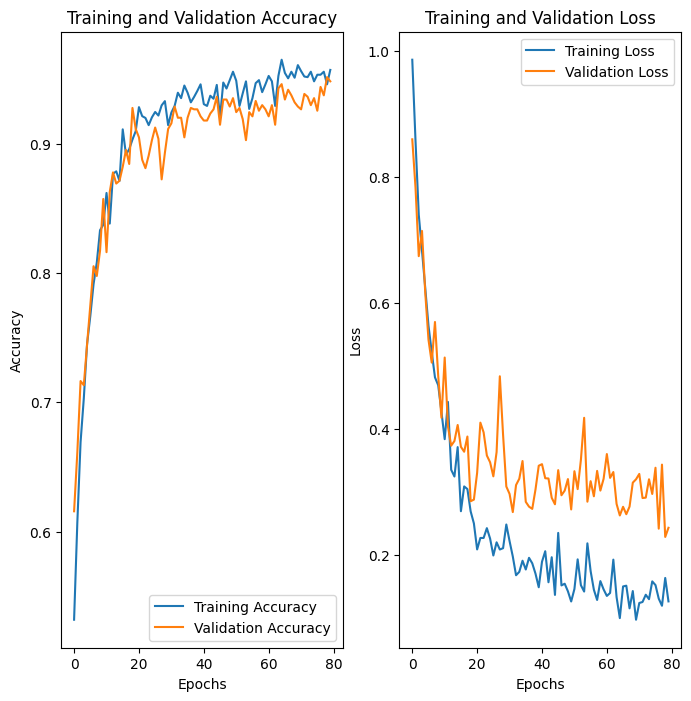

In [66]:
plt.figure(figsize=(8,8))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCH), acc, label='Training Accuracy')
plt.plot(range(EPOCH), val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCH), loss, label='Training Loss')
plt.plot(range(EPOCH), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')


plt.show()

29/29 [==============================] - 0s 3ms/step


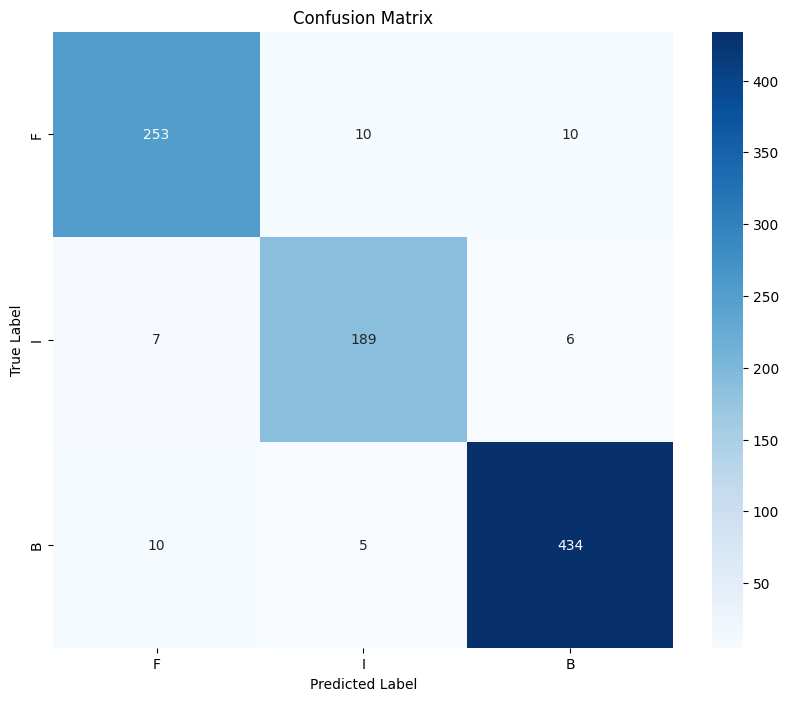

In [67]:
y_pred = model.predict(X_test_ann)
y_pred_classes = [list(wav_dict.keys())[i] for i in np.argmax(y_pred, axis=1)]
y_true_classes = [list(wav_dict.keys())[i] for i in np.argmax(y_test_ann, axis=1)]

# Tạo ma trận sai lầm
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Vẽ biểu đồ ma trận sai lầm
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(wav_dict.keys()), yticklabels=list(wav_dict.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()